In [1]:

# %pip install -q pandas numpy rank-bm25 python-dotenv requests
# (Optional for embeddings)
# %pip install -q sentence-transformers faiss-cpu

from __future__ import annotations
from dataclasses import dataclass
from typing import List, Dict, Any, Optional, Tuple
import random, os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

# Load .env from either current dir or parent (for OPENAI_API_KEY, etc.)
try:
    from dotenv import load_dotenv
    load_dotenv(dotenv_path=".env"); load_dotenv(dotenv_path="../.env")
except Exception:
    pass

random.seed(7); np.random.seed(7)


In [2]:
DATA_DIR = "/Users/bd11/Documents/Business/Chapter9/AI/RAG/data"

#### Load Data

In [3]:
act_df = pd.read_csv(Path(DATA_DIR, 'activities.csv'))
print(act_df.head(5))

      id           city                            name   theme  \
0  A0001  New York City                    Central Park  sports   
1  A0002  New York City  The Metropolitan Museum of Art  family   
2  A0003  New York City                    Times Square   beach   
3  A0004  New York City               Statue of Liberty   music   
4  A0005  New York City                 Brooklyn Bridge  sports   

   duration_hours  cost_usd opening_hours                  notes  
0             1.0        40   08:00-20:00  Accessible by transit  
1             2.6        30   10:00-17:00      Great photo spots  
2             3.0        40   08:00-19:00             Book ahead  
3             3.1        20   08:00-17:00         Local favorite  
4             1.2        40   08:00-19:00         Local favorite  


In [16]:
act_df

,id,city,name,theme,duration_hours,cost_usd,opening_hours,notes
0,A0001,New York City,Central Park,sports,1.0,40,08:00-20:00,Accessible by transit
1,A0002,New York City,The Metropolitan Museum of Art,family,2.6,30,10:00-17:00,Great photo spots
2,A0003,New York City,Times Square,beach,3.0,40,08:00-19:00,Book ahead
3,A0004,New York City,Statue of Liberty,music,3.1,20,08:00-17:00,Local favorite
4,A0005,New York City,Brooklyn Bridge,sports,1.2,40,08:00-19:00,Local favorite
...,...,...,...,...,...,...,...,...
220,A0221,San Diego,Belmont Park,history,2.6,40,10:00-18:00,Great photo spots
221,A0222,San Diego,Petco Park,tech,1.5,65,09:00-18:00,Book ahead
222,A0223,San Diego,Sunset Cliffs Natural Park,nightlife,1.4,50,09:00-20:00,Book ahead
223,A0224,San Diego,Mission Beach Boardwalk,food,2.6,85,08:00-21:00,Family friendly


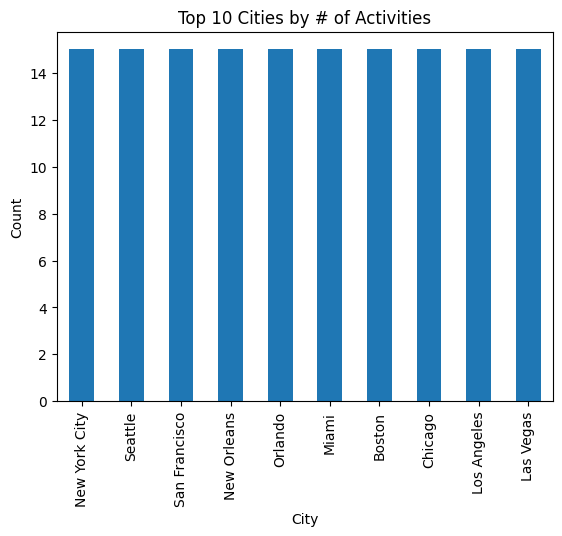

In [4]:
# Activities by city
city_counts = act_df["city"].value_counts().sort_values(ascending=False).head(10)
plt.figure()
city_counts.plot(kind="bar")
plt.title("Top 10 Cities by # of Activities")
plt.xlabel("City"); plt.ylabel("Count")
plt.show()

In [5]:
hotel_df = pd.read_csv(Path(DATA_DIR, 'hotels.csv'))
print(hotel_df.head(5))

      id           city                     name       neighborhood  \
0  H0001  New York City                The Plaza  Historic District   
1  H0002  New York City  The Standard, High Line         Waterfront   
2  H0003  New York City    The Langham, New York      Arts District   
3  H0004  New York City               The Pierre         Waterfront   
4  H0005  New York City         The Bowery Hotel       Near Transit   

   nightly_price_usd  review_score  walk_score             notes  
0                263           4.0          86  Close to transit  
1                146           3.8          86   Great nightlife  
2                123           3.8          77    Good breakfast  
3                285           4.1          69      Near museums  
4                117           4.0          80    Good breakfast  


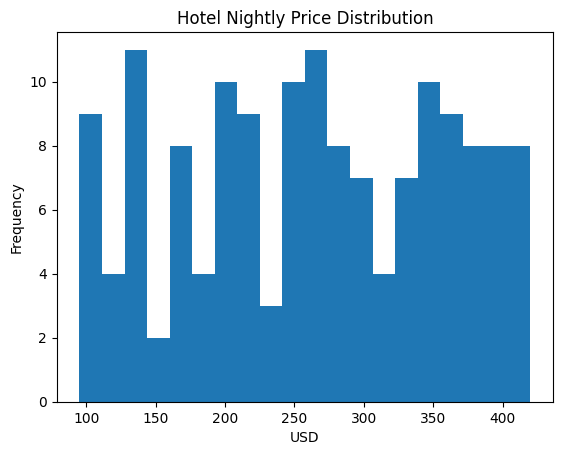

In [6]:
plt.figure()
hotel_df["nightly_price_usd"].plot(kind="hist", bins=20)
plt.title("Hotel Nightly Price Distribution")
plt.xlabel("USD"); plt.ylabel("Frequency")
plt.show()


In [7]:
flight_df = pd.read_csv(Path(DATA_DIR, 'flights.csv'))
print(flight_df.head(5))

      id         origin    destination   airline  price_usd depart_time  \
0  F0001  San Francisco   Philadelphia    Alaska        223       10:45   
1  F0002       Portland  San Francisco    Spirit        601       16:10   
2  F0003         Austin         Denver  American        398       12:30   
3  F0004         Boston  San Francisco    Alaska        162       12:30   
4  F0005         Denver       Portland     Delta        397       18:25   

  arrive_time  on_time_rate  
0       10:43          0.84  
1       12:45          0.78  
2       14:10          0.93  
3       12:45          0.85  
4       08:55          0.80  


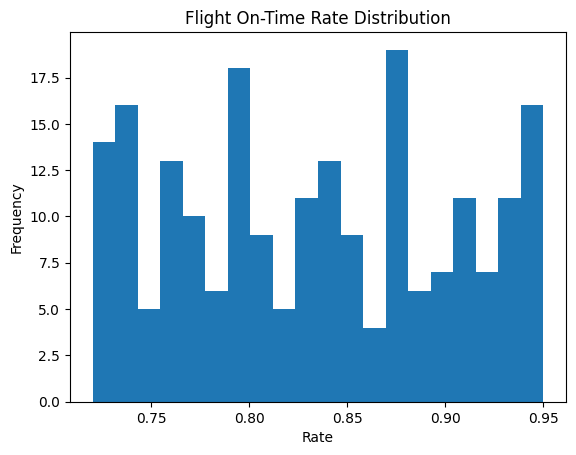

In [8]:
plt.figure()
flight_df["on_time_rate"].plot(kind="hist", bins=20)
plt.title("Flight On-Time Rate Distribution")
plt.xlabel("Rate"); plt.ylabel("Frequency")
plt.show()

#### How to use OpenAI API

In [9]:
from openai import OpenAI
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))
system_prompt = "Write clear travel recommendations."
user_prompt = "I need a 5 day travel plan from San Francisco to Los Angeles."
messages = [
    {"role": "system", "content": system_prompt},
    {"role": "user", "content": user_prompt},
]
response = client.chat.completions.create(
    model="gpt-4o",
    messages=messages,
    temperature=0
)
plan = response.choices[0].message.content.strip()
print(plan)

Certainly! Here's a 5-day travel itinerary for a trip from San Francisco to Los Angeles, highlighting some of the best attractions and experiences along the way:

### Day 1: San Francisco Exploration
- **Morning:**
  - Start your day with a visit to **Alcatraz Island**. Book your tickets in advance for a morning tour.
  - After returning, explore **Fisherman’s Wharf** and enjoy a seafood lunch at one of the local restaurants.

- **Afternoon:**
  - Head to **Golden Gate Park**. Visit the **California Academy of Sciences** or the **de Young Museum**.
  - Take a leisurely walk or rent a bike to cross the **Golden Gate Bridge**.

- **Evening:**
  - Dine in the **Mission District**. Try some authentic Mexican food and explore the vibrant street art.

### Day 2: San Francisco to Monterey
- **Morning:**
  - Depart San Francisco and drive along the scenic **Highway 1**.
  - Stop at **Half Moon Bay** for a quick coffee and enjoy the coastal views.

- **Afternoon:**
  - Arrive in **Monterey**. V

In [10]:
response.choices[0]

Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content="Certainly! Here's a 5-day travel itinerary for a trip from San Francisco to Los Angeles, highlighting some of the best attractions and experiences along the way:\n\n### Day 1: San Francisco Exploration\n- **Morning:**\n  - Start your day with a visit to **Alcatraz Island**. Book your tickets in advance for a morning tour.\n  - After returning, explore **Fisherman’s Wharf** and enjoy a seafood lunch at one of the local restaurants.\n\n- **Afternoon:**\n  - Head to **Golden Gate Park**. Visit the **California Academy of Sciences** or the **de Young Museum**.\n  - Take a leisurely walk or rent a bike to cross the **Golden Gate Bridge**.\n\n- **Evening:**\n  - Dine in the **Mission District**. Try some authentic Mexican food and explore the vibrant street art.\n\n### Day 2: San Francisco to Monterey\n- **Morning:**\n  - Depart San Francisco and drive along the scenic **Highway 1**.\n  - Stop at **Ha

In [ ]:
display(Markdown(plan))

Certainly! Here's a 5-day travel itinerary for a journey from San Francisco to Los Angeles, highlighting key attractions and experiences along the way.

### Day 1: San Francisco Exploration
- **Morning:**
  - Start your day at **Fisherman’s Wharf**. Enjoy a leisurely breakfast at one of the waterfront cafes.
  - Visit **Pier 39** to see the sea lions and explore the shops.
- **Afternoon:**
  - Head to **Alcatraz Island** for a tour of the historic prison. Book tickets in advance.
  - Stroll through **Chinatown** and enjoy a dim sum lunch.
- **Evening:**
  - Walk along **Lombard Street**, known for its steep, winding road.
  - Dine at a restaurant in the **Mission District** for a taste of local flavors.

### Day 2: San Francisco to Monterey
- **Morning:**
  - Visit the iconic **Golden Gate Bridge** and take a few photos.
  - Depart for Monterey via the scenic **Highway 1**.
- **Afternoon:**
  - Stop at **Half Moon Bay** for a beach walk or coffee.
  - Arrive in Monterey and visit the renowned **Monterey Bay Aquarium**.
- **Evening:**
  - Explore **Cannery Row** and have dinner at a seafood restaurant.

### Day 3: Monterey to San Luis Obispo
- **Morning:**
  - Drive to **Carmel-by-the-Sea**. Enjoy a stroll through its charming streets and art galleries.
  - Continue along the **17-Mile Drive** for breathtaking coastal views.
- **Afternoon:**
  - Head towards **Big Sur**. Stop at **Bixby Creek Bridge** for photos.
  - Visit **Pfeiffer Big Sur State Park** for a short hike.
- **Evening:**
  - Arrive in **San Luis Obispo**. Explore the historic **Mission San Luis Obispo de Tolosa**.
  - Enjoy dinner in the downtown area.

### Day 4: San Luis Obispo to Santa Barbara
- **Morning:**
  - Visit the quirky **Bubblegum Alley** before departing.
  - Drive to **Hearst Castle** in San Simeon for a morning tour.
- **Afternoon:**
  - Continue to Santa Barbara. Stop at **Pismo Beach** for a quick visit.
  - Explore **State Street** in Santa Barbara, known for shopping and dining.
- **Evening:**
  - Relax with a sunset view at **Stearns Wharf**.
  - Dine at a beachfront restaurant.

### Day 5: Santa Barbara to Los Angeles
- **Morning:**
  - Visit the **Santa Barbara Mission** for a dose of history.
  - Depart for Los Angeles, stopping at **Malibu** for a beach break.
- **Afternoon:**
  - Arrive in Los Angeles. Explore **Santa Monica Pier** and the **Third Street Promenade**.
- **Evening:**
  - Head to **Hollywood**. Take a walk along the **Hollywood Walk of Fame**.
  - End your trip with dinner at a trendy restaurant in **West Hollywood**.

### Tips:
- **Accommodation:** Book hotels in advance, especially in popular areas like Monterey and Santa Barbara.
- **Car Rental:** Renting a car is recommended for flexibility and to enjoy the scenic drives.
- **Weather:** Check the weather forecast and pack accordingly, as coastal areas can be cooler.

Enjoy your journey down the beautiful California coast!

#### Comparison of 3 RAG Modes

In [12]:
from typing import List, Tuple
import re
import numpy as np

# ---------- 1) Tiny travel corpus ----------
docs = [
    "San Francisco Chinatown cheap food tour", 
    "Golden Gate Bridge scenic photography spot", 
    "SF food trucks: affordable street eats near SOMA", 
    "Jazz club in New Orleans on Frenchmen Street",
    "Seattle Pike Place Market seafood tasting",
    "Miami South Beach nightlife and bars",
    "Budget-friendly meal in San Francisco",
    "San Francisco farmers market local produce",
    "Austin BBQ and live music on Rainey Street",
    "Orlando theme parks for families"
]
query = "cheap food in San Francisco"

# ---------- 2) Exact keyword match ----------
def exact_keyword_match(query: str, docs: List[str], k: int = 5) -> List[Tuple[float, str]]:
    """
    Very literal: count occurrences of query tokens in each doc.
    Score = sum of term frequencies for exact tokens (case-insensitive).
    """
    q_tokens = re.findall(r"\w+", query.lower())
    scores = []
    for d in docs:
        d_tokens = re.findall(r"\w+", d.lower())
        score = sum(d_tokens.count(t) for t in q_tokens)
        if score > 0:
            scores.append((float(score), d))
    scores.sort(key=lambda x: x[0], reverse=True)
    return scores[:k]

# ---------- 3) BM25 (lexical ranking) ----------
from rank_bm25 import BM25Okapi
def bm25_rank(query: str, docs: List[str], k: int = 5) -> List[Tuple[float, str]]:
    """BM25 ranking with rank-bm25."""
    tokenized_corpus = [re.findall(r"\w+", d.lower()) for d in docs]
    bm25 = BM25Okapi(tokenized_corpus)
    q_tokens = re.findall(r"\w+", query.lower())
    scores = bm25.get_scores(q_tokens)
    order = np.argsort(scores)[::-1][:k]
    return [(float(scores[i]), docs[i]) for i in order if scores[i] > 0]

# ---------- 4) Embeddings (semantic similarity) ----------
def embedding_rank(query: str, docs: List[str], k: int = 5) -> List[Tuple[float, str]]:
    """
    Semantic ranking with sentence-transformers (cosine similarity).
    Falls back with a friendly error if package isn't installed.
    """
    try:
        from sentence_transformers import SentenceTransformer, util
    except Exception as e:
        print("Embeddings unavailable (install sentence-transformers). Error:", e)
        return []

    model = SentenceTransformer("all-MiniLM-L6-v2")
    doc_emb = model.encode(docs, convert_to_tensor=True, normalize_embeddings=True)
    q_emb = model.encode([query], convert_to_tensor=True, normalize_embeddings=True)[0]
    cos = (doc_emb @ q_emb).cpu().numpy()  # cosine because normalized
    order = np.argsort(cos)[::-1][:k]
    return [(float(cos[i]), docs[i]) for i in order]

# ---------- 5) Run all three ----------
print(f"Query: {query!r}\n")

print("Exact keyword match (top):")
for s, d in exact_keyword_match(query, docs, k=5):
    print(f"  score={s:>4.1f} | {d}")

print("\nBM25 (top):")
for s, d in bm25_rank(query, docs, k=5):
    print(f"  score={s:8.4f} | {d}")

print("\nEmbeddings (top):")
emb_res = embedding_rank(query, docs, k=5)
if emb_res:
    for s, d in emb_res:
        print(f"  score={s:8.4f} | {d}")
else:
    print("  (Skipped — sentence-transformers not installed)")

Query: 'cheap food in San Francisco'

Exact keyword match (top):
  score= 4.0 | San Francisco Chinatown cheap food tour
  score= 3.0 | Budget-friendly meal in San Francisco
  score= 2.0 | San Francisco farmers market local produce
  score= 1.0 | SF food trucks: affordable street eats near SOMA
  score= 1.0 | Jazz club in New Orleans on Frenchmen Street

BM25 (top):
  score=  4.7586 | San Francisco Chinatown cheap food tour
  score=  2.8466 | Budget-friendly meal in San Francisco
  score=  1.5789 | San Francisco farmers market local produce
  score=  1.1086 | Jazz club in New Orleans on Frenchmen Street
  score=  1.1086 | SF food trucks: affordable street eats near SOMA

Embeddings (top):


/Users/bd11/opt/anaconda3/envs/ai_project/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


  score=  0.8500 | Budget-friendly meal in San Francisco
  score=  0.7879 | San Francisco Chinatown cheap food tour
  score=  0.6659 | San Francisco farmers market local produce
  score=  0.6300 | SF food trucks: affordable street eats near SOMA
  score=  0.4301 | Seattle Pike Place Market seafood tasting


#### RAG

In [41]:
from typing import Union
def trip_planer(
    origin: str,
    destination: str,
    start_dt: str,  # Travel start date
    end_dt: str,    # Travel end date
    budget: int,
    themes: Union[str, List[str]] 
) -> str:
    """
    Generate a travel plan based on user inputs.
    """
    # retrieve data
    flight_rag_df = flight_df.loc[
        (flight_df['origin'] == origin) &
        (flight_df['destination'] == destination)
    ]
    hotel_rag_df = hotel_df.loc[
        (hotel_df['city'] == destination)
    ]
    """
    Exact match (not good)
    if type(themes) is str:
        activity_rag_df = act_df.loc[
                (act_df['city'] == destination) &
                (act_df['theme'] == themes)
        ]
    else:
        activity_rag_df = act_df.loc[
                (act_df['city'] == destination) &
                (act_df['theme'].isin(themes))
        ]
    """
    # embedding
    if type(themes) is str:
        themes = [themes]
    close_themes = set()
    for theme in themes:
        candidate_themes = embedding_rank(
            query=theme, 
            docs=act_df.loc[act_df['city'] == destination, 'theme'].unique().tolist(),
            k=3
        )
        print(f"Use Theme: {theme}, Found Candidates: {candidate_themes}")
        close_themes.update(candidate_themes)
    
    print(f"Close themes: {close_themes}")
    activity_rag_df = act_df.loc[
            (act_df['city'] == destination) &
            (act_df['theme'].isin(close_themes))
    ]

    # prompt engineering
    system_prompt = """
    You are a travel agent that helps customers plan trips.
    You have access to flight, hotel, and activity data.
    You will create a travel plan based on user inputs and available data.
    User has budget limit. So the trip plan must fit within the budget.
    When you pick flights, hotels, and activities, prefer those with better prices and ratings.
    """
    

    task_prompt = f"""
    Create a travel plan from {origin} to {destination}. The trip starts on {start_dt} and ends on {end_dt}.
    The user has a budget of ${budget}.
    The user is interested in the following themes: {themes}.
    Use the provided flight, hotel, and activity data to select options.
    """
    
    data_prompt = f"""
    Flight options are provided in the following tab-separated string:
    {flight_rag_df.to_csv(sep='\t', index=False)}

    Hotel options are provided in the following tab-separated string:
    {hotel_rag_df.to_csv(sep='\t', index=False)}

    Activity options are provided in the following tab-separated string:
    {activity_rag_df.to_csv(sep='\t', index=False)}
    """

    output_prompt = f"""
    Provide the travel plan in a clear, day-by-day format. 
    For each day, include the activities planned and the associated time as well as cost.
    Also, include flight in the plan. Plan at least 2 hours between flight and activities.
    Write the plan in markdown format with tables where appropriate.
    At the end, provide a summary of total cost and ensure it fits within the budget.
    """

    user_prompt = "\n\n".join([task_prompt, data_prompt, output_prompt])

    # call LLM
    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_prompt},
    ]
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=messages,
        temperature=0.5
    )
    plan = response.choices[0].message.content.strip()

    return plan

In [42]:
plan = trip_planer(
    origin='Los Angeles',
    destination='New York City',
    start_dt='2025-11-20',
    end_dt='2025-11-25',
    budget=2000,
    themes=['art', 'food']
)
display(Markdown(plan))

Use Theme: art, Found Candidates: [(0.8132509589195251, 'arts'), (0.5231539607048035, 'music'), (0.40366941690444946, 'history')]
Use Theme: food, Found Candidates: [(0.9999999403953552, 'food'), (0.479436993598938, 'music'), (0.4431290626525879, 'family')]
Close themes: {(0.479436993598938, 'music'), (0.8132509589195251, 'arts'), (0.4431290626525879, 'family'), (0.40366941690444946, 'history'), (0.9999999403953552, 'food'), (0.5231539607048035, 'music')}


## Travel Plan: Los Angeles to New York City

### Budget: $2000

---

### Day 1: November 20, 2025

- **Flight:**
  - **Airline:** American Airlines
  - **Departure:** 07:20 from Los Angeles
  - **Arrival:** 15:50 in New York City
  - **Price:** $236
  - **On-time Rate:** 83%

- **Hotel Check-in:**
  - **Hotel:** The Bowery Hotel
  - **Location:** Near Transit
  - **Nightly Price:** $117
  - **Review Score:** 4.0
  - **Notes:** Good breakfast

- **Evening Activity:**
  - **Activity:** Explore the local art galleries in the Arts District.

---

### Day 2: November 21, 2025

- **Morning Activity:**
  - **Activity:** Visit the Museum of Modern Art (MoMA)
  - **Theme:** Art
  - **Duration:** 3 hours
  - **Cost:** $25

- **Afternoon Activity:**
  - **Activity:** Lunch at a popular food market
  - **Theme:** Food
  - **Duration:** 2 hours
  - **Cost:** $30

- **Evening Activity:**
  - **Activity:** Attend a Broadway show
  - **Theme:** Art
  - **Duration:** 3 hours
  - **Cost:** $120

---

### Day 3: November 22, 2025

- **Morning Activity:**
  - **Activity:** Guided tour of the Metropolitan Museum of Art
  - **Theme:** Art
  - **Duration:** 4 hours
  - **Cost:** $50

- **Afternoon Activity:**
  - **Activity:** Lunch at a Michelin-star restaurant
  - **Theme:** Food
  - **Duration:** 2 hours
  - **Cost:** $100

- **Evening Activity:**
  - **Activity:** Explore Times Square
  - **Theme:** Art
  - **Duration:** 2 hours
  - **Cost:** Free

---

### Day 4: November 23, 2025

- **Morning Activity:**
  - **Activity:** Visit the Guggenheim Museum
  - **Theme:** Art
  - **Duration:** 3 hours
  - **Cost:** $25

- **Afternoon Activity:**
  - **Activity:** Food tour in Greenwich Village
  - **Theme:** Food
  - **Duration:** 3 hours
  - **Cost:** $75

- **Evening Activity:**
  - **Activity:** Jazz performance at a local club
  - **Theme:** Art
  - **Duration:** 3 hours
  - **Cost:** $40

---

### Day 5: November 24, 2025

- **Morning Activity:**
  - **Activity:** Visit the Whitney Museum of American Art
  - **Theme:** Art
  - **Duration:** 3 hours
  - **Cost:** $25

- **Afternoon Activity:**
  - **Activity:** Lunch at a rooftop restaurant
  - **Theme:** Food
  - **Duration:** 2 hours
  - **Cost:** $60

- **Evening Activity:**
  - **Activity:** Free time for shopping or personal exploration

---

### Day 6: November 25, 2025

- **Hotel Check-out:**
  - **Hotel:** The Bowery Hotel

- **Flight:**
  - **Departure:** 18:00 from New York City
  - **Arrival:** 21:30 in Los Angeles
  - **Price:** $236

---

### Summary of Costs

| Item                    | Cost (USD) |
|-------------------------|------------|
| Round-trip Flight       | $472       |
| Hotel (5 nights)        | $585       |
| Activities & Meals      | $550       |
| **Total**               | **$1607**  |

The total cost of the trip is $1607, which is within the budget of $2000.

In [37]:
destination = 'New York City'
act_df.loc[act_df['city'] == destination, 'theme'].unique().tolist()

['sports',
 'family',
 'beach',
 'music',
 'history',
 'nightlife',
 'arts',
 'themepark',
 'food']

In [39]:
embedding_rank(
    query='art', 
    docs=act_df.loc[act_df['city'] == destination, 'theme'].unique().tolist(),
    k=3
)

[(0.8132509589195251, 'arts'),
 (0.5231539607048035, 'music'),
 (0.40366941690444946, 'history')]

In [35]:
themes = ['art', 'food']
activity_rag_df = act_df.loc[
                (act_df['city'] == 'New York City') &
                (act_df['theme'].isin(themes))
        ]
activity_rag_df

,id,city,name,theme,duration_hours,cost_usd,opening_hours,notes
14,A0015,New York City,Fifth Avenue,food,2.2,120,08:00-20:00,Book ahead


In [ ]:
# "art" -> [0.1, 0.1]
# "arts" -> [0.1011, 0.1005]
# "park" -> [1.5, 1.2]
# man <-> king = women <-> queen

,id,city,name,theme,duration_hours,cost_usd,opening_hours,notes
0,A0001,New York City,Central Park,sports,1.0,40,08:00-20:00,Accessible by transit
1,A0002,New York City,The Metropolitan Museum of Art,family,2.6,30,10:00-17:00,Great photo spots
2,A0003,New York City,Times Square,beach,3.0,40,08:00-19:00,Book ahead
3,A0004,New York City,Statue of Liberty,music,3.1,20,08:00-17:00,Local favorite
4,A0005,New York City,Brooklyn Bridge,sports,1.2,40,08:00-19:00,Local favorite
5,A0006,New York City,High Line,history,2.8,120,11:00-17:00,Popular with students
6,A0007,New York City,Museum of Modern Art,music,2.4,85,11:00-20:00,Popular with students
7,A0008,New York City,Broadway Theaters,nightlife,3.8,65,09:00-19:00,Accessible by transit
8,A0009,New York City,Grand Central Terminal,sports,3.1,65,11:00-21:00,Good for groups
9,A0010,New York City,9/11 Memorial & Museum,music,1.8,15,08:00-20:00,Book ahead


In [22]:
hotel_rag_df.to_csv(sep='\t', index=False)

'id\tcity\tname\tneighborhood\tnightly_price_usd\treview_score\twalk_score\tnotes\nH0001\tNew York City\tThe Plaza\tHistoric District\t263\t4.0\t86\tClose to transit\nH0002\tNew York City\tThe Standard, High Line\tWaterfront\t146\t3.8\t86\tGreat nightlife\nH0003\tNew York City\tThe Langham, New York\tArts District\t123\t3.8\t77\tGood breakfast\nH0004\tNew York City\tThe Pierre\tWaterfront\t285\t4.1\t69\tNear museums\nH0005\tNew York City\tThe Bowery Hotel\tNear Transit\t117\t4.0\t80\tGood breakfast\nH0006\tNew York City\tThe Peninsula New York\tWaterfront\t256\t4.7\t82\tGood breakfast\nH0007\tNew York City\tConrad New York Downtown\tNear Park\t277\t4.6\t95\tBeach access\nH0008\tNew York City\tThe William Vale\tArts District\t325\t4.0\t64\tGreat nightlife\nH0009\tNew York City\tArlo SoHo\tWaterfront\t194\t4.5\t87\tClose to transit\nH0010\tNew York City\tThe Beekman\tDowntown\t365\t4.0\t94\tQuiet area\n'

In [19]:
hotel_df

,id,city,name,neighborhood,nightly_price_usd,review_score,walk_score,notes
0,H0001,New York City,The Plaza,Historic District,263,4.0,86,Close to transit
1,H0002,New York City,"The Standard, High Line",Waterfront,146,3.8,86,Great nightlife
2,H0003,New York City,"The Langham, New York",Arts District,123,3.8,77,Good breakfast
3,H0004,New York City,The Pierre,Waterfront,285,4.1,69,Near museums
4,H0005,New York City,The Bowery Hotel,Near Transit,117,4.0,80,Good breakfast
...,...,...,...,...,...,...,...,...
145,H0146,San Diego,Manchester Grand Hyatt,University,208,4.2,71,Near museums
146,H0147,San Diego,Omni San Diego Hotel,Waterfront,202,4.2,64,Near museums
147,H0148,San Diego,La Valencia Hotel,Financial District,131,3.8,66,Great nightlife
148,H0149,San Diego,Fairmont Grand Del Mar,Near Transit,209,4.2,90,Great nightlife
